<a href="https://colab.research.google.com/github/fatjan/learn-tensorflow/blob/master/SingleLayerNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Series

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [4]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5



Create The Series

In [5]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.02913873],
       [ 0.00747427],
       [ 0.04669853],
       [-0.02787512],
       [-0.05315021],
       [ 0.05625639],
       [ 0.01050403],
       [-0.00820793],
       [-0.06057311],
       [ 0.08738344],
       [-0.01086302],
       [-0.00542401],
       [-0.06047838],
       [ 0.05474481],
       [ 0.01025063],
       [ 0.06129548],
       [-0.00063508],
       [ 0.21795447],
       [ 0.20745318],
       [ 0.48515138]], dtype=float32), array([0.013986], dtype=float32)]


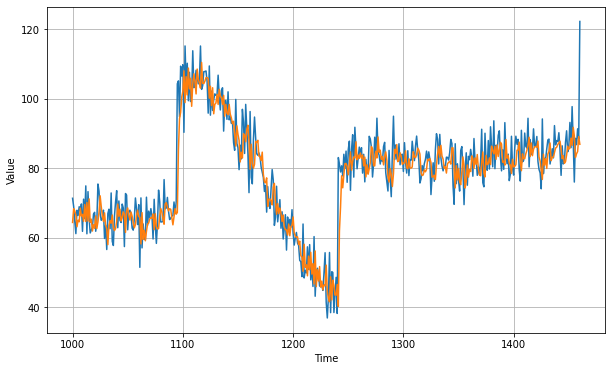

In [16]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size :]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.054749